# Análise dos dfs
- Primeiras investigações mostraram aparente falta de dados de acidentes a partir de 2024 (minha suspeita)
- Aqui foi filtrado para até 31/12/2023

In [1]:
import pandas as pd
from pathlib import Path

path_util_data = Path("util_data")

df_acidentes = pd.read_csv(f"{path_util_data}/acidentes_brs_040_060.csv")
df_acidentes = df_acidentes[df_acidentes['timestamp_utc']<"2024"]
df_met = pd.read_csv(f"{path_util_data}/meteorologia_brs_040_060.csv")
df_met.columns = ['timestamp_utc'] + df_met.columns.tolist()[1:]
df_met = df_met[df_met['timestamp_utc']<'2024']


df_met['timestamp_utc'] = pd.to_datetime(df_met['timestamp_utc'], utc=True)
df_met = (
    df_met
    .set_index('timestamp_utc')   # ← efetivamente define o índice
    .sort_index()
    .asfreq('h')                  # cria linhas vazias onde faltarem horas
)

print('df_acidentes')
display(df_acidentes.tail(3))
print('df_meteorologia')
df_met.tail(3)

df_acidentes


,data,horario,n_da_ocorrencia,tipo_de_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,...,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,vl_br,timestamp_utc,latitude_acidente,longitude_acidente
4326,22/12/2023,09:23:00,347,Acidente c,8.24,BR-040/DF,Sul,Colisão traseira,1,0,...,0,0,1,0,0,0,40,2023-12-22 12:23:00+00:00,-16.049821,-47.981521
4327,24/12/2023,04:41:00,134,Acidente c,5.80,BR-040/DF,Sul,Colisão traseira,2,0,...,0,2,0,0,0,0,40,2023-12-24 07:41:00+00:00,-16.028002,-47.979099
4328,24/12/2023,11:22:00,188,Acidente c,6.20,BR-040/DF,Sul,Atropelamento de Pedestre,1,0,...,0,1,0,0,1,0,40,2023-12-24 14:22:00+00:00,-16.031598,-47.978825


df_meteorologia


,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
timestamp_utc,,,,,,,,,,,,,,,,,
2023-12-31 21:00:00+00:00,0.0,901.1,901.2,900.8,631.6,25.9,18.3,27.7,25.7,18.3,17.0,63.0,53.0,63.0,301.0,6.4,2.8
2023-12-31 22:00:00+00:00,0.0,902.0,902.0,901.1,128.8,23.8,18.5,25.9,23.8,18.7,18.1,72.0,62.0,72.0,321.0,4.8,0.8
2023-12-31 23:00:00+00:00,0.0,902.7,902.7,902.0,0.0,22.7,18.9,23.8,22.5,19.1,18.4,81.0,72.0,79.0,330.0,2.5,1.8


# Agregação horária
- Contagem simples de acidentes agrupados por hora para análise e merge com dados meteorologicos

In [2]:
# garante que a coluna está em datetime64[ns, UTC] (ou já está)
df_acidentes['timestamp_utc'] = pd.to_datetime(df_acidentes['timestamp_utc'], utc=True)

# cria a série de contagem horária
counts_hourly = (
    df_acidentes
    .set_index('timestamp_utc')   # índice = instantes
    .resample('h')                # frequência de 1 hora
    .size()                       # conta linhas por intervalo
    .rename('count')              # (opcional) nome da série
    .asfreq('h', fill_value=0)    # garante horas vazias = 0
)

counts_hourly.head(2)


timestamp_utc
2014-09-04 05:00:00+00:00    1
2014-09-04 06:00:00+00:00    0
Freq: h, Name: count, dtype: int64

In [3]:
df_h = pd.concat([df_met, counts_hourly], axis=1).fillna(0)
df_h

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",count
timestamp_utc,,,,,,,,,,,,,,,,,,
2014-09-04 04:00:00+00:00,0.0,887.5,887.9,887.5,1.6,17.8,14.6,18.9,17.8,14.8,14.0,81.0,73.0,81.0,21.0,3.6,2.2,0.0
2014-09-04 05:00:00+00:00,0.0,887.5,887.9,887.4,0.0,18.0,16.4,18.3,17.5,16.9,14.5,92.0,79.0,90.0,116.0,4.8,2.5,1.0
2014-09-04 06:00:00+00:00,0.0,887.3,887.6,887.2,0.0,17.4,15.9,18.3,17.4,16.5,15.7,91.0,85.0,91.0,11.0,4.1,0.6,0.0
2014-09-04 07:00:00+00:00,0.0,887.0,887.4,886.9,0.0,17.8,16.8,17.8,17.2,17.0,15.8,96.0,91.0,94.0,85.0,2.9,1.3,0.0
2014-09-04 08:00:00+00:00,0.0,887.2,887.2,887.0,0.0,17.5,17.0,17.8,16.5,17.1,16.0,98.0,93.0,97.0,154.0,2.8,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00+00:00,0.0,901.5,902.6,901.5,2391.9,28.2,16.6,28.8,27.7,18.7,16.3,55.0,49.0,49.0,303.0,6.0,3.3,0.0
2023-12-31 20:00:00+00:00,0.0,901.2,901.6,901.2,1330.1,27.5,17.6,28.5,27.1,18.1,16.5,56.0,49.0,55.0,302.0,5.9,3.5,0.0
2023-12-31 21:00:00+00:00,0.0,901.1,901.2,900.8,631.6,25.9,18.3,27.7,25.7,18.3,17.0,63.0,53.0,63.0,301.0,6.4,2.8,0.0


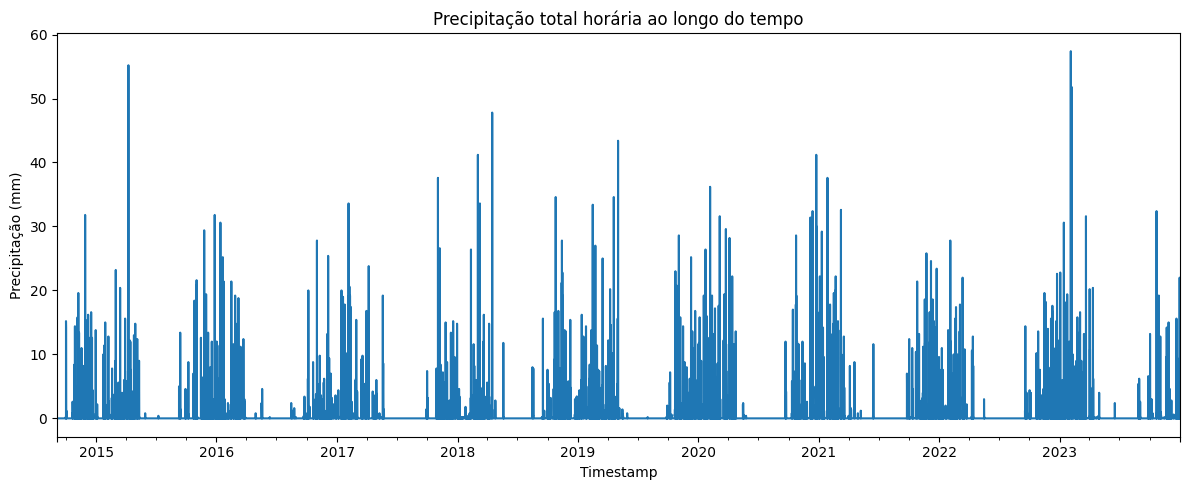

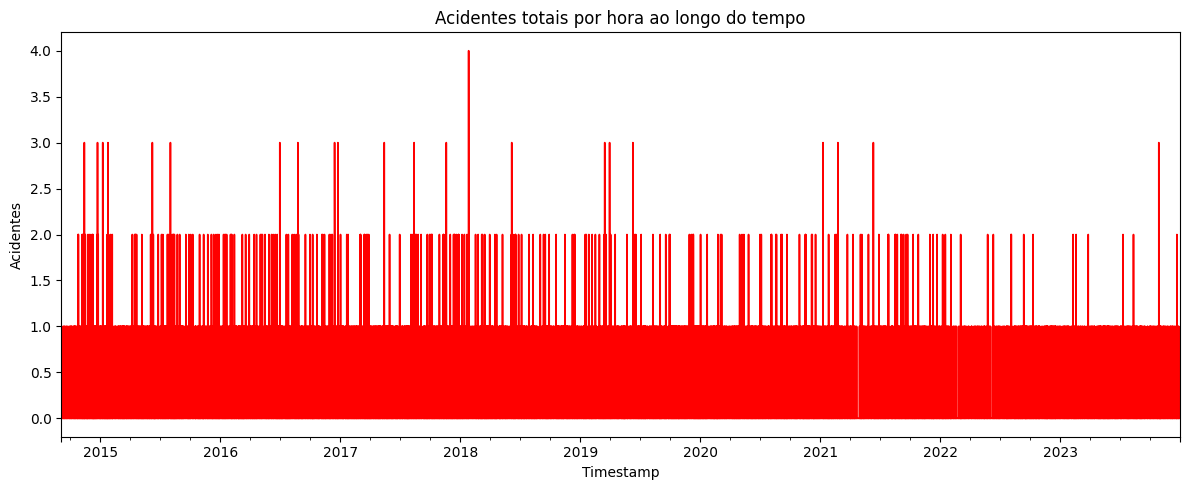

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))          # único gráfico
df_h["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].plot()

plt.xlabel("Timestamp")
plt.ylabel("Precipitação (mm)")
plt.title("Precipitação total horária ao longo do tempo")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
df_h["count"].plot(color="red", linewidth=1.2)  # ← linha vermelha
plt.xlabel("Timestamp")
plt.ylabel("Acidentes")
plt.title("Acidentes totais por hora ao longo do tempo")
plt.tight_layout()
plt.show()

# Análise mensal e coerencia anual

In [5]:
df_month = (
    df_h.resample("ME")                       # mês termina no último dia
        .agg({
            "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "sum",
            "count": "sum"
        })
        .rename(columns={
            "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "precip_total_mm",
            "count": "acidentes_mes"
        })
)

df_month.head(3)

,precip_total_mm,acidentes_mes
timestamp_utc,,
2014-09-30 00:00:00+00:00,0.2,14.0
2014-10-31 00:00:00+00:00,93.3,31.0
2014-11-30 00:00:00+00:00,247.2,67.0


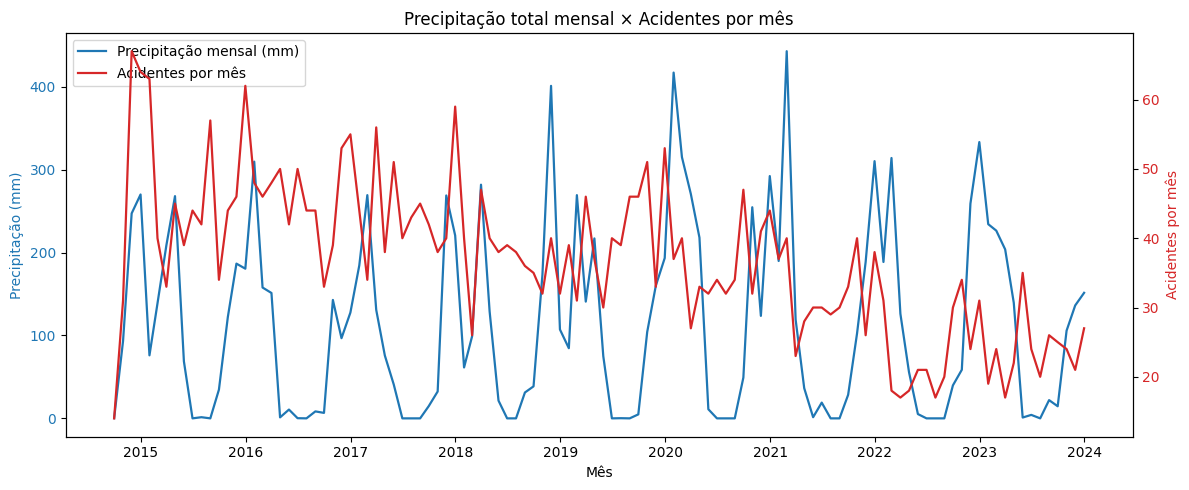

In [6]:
import matplotlib.pyplot as plt

# Verifica df_month
if 'df_month' not in globals():
    raise NameError("O DataFrame 'df_month' ainda não foi criado. Execute a agregação mensal primeiro.")

fig, ax1 = plt.subplots(figsize=(12, 5))

# Linha de precipitação mensal
ax1.plot(
    df_month.index,
    df_month["precip_total_mm"],
    color="tab:blue",
    linewidth=1.6,
    label="Precipitação mensal (mm)"
)
ax1.set_xlabel("Mês")
ax1.set_ylabel("Precipitação (mm)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Linha de acidentes mensais, eixo secundário
ax2 = ax1.twinx()
ax2.plot(
    df_month.index,
    df_month["acidentes_mes"],
    color="tab:red",
    linewidth=1.6,
    label="Acidentes por mês"
)
ax2.set_ylabel("Acidentes por mês", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Legenda conjunta
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Precipitação total mensal × Acidentes por mês")
plt.tight_layout()
plt.show()


# Relatório espectral (sugerido pelo GPT)

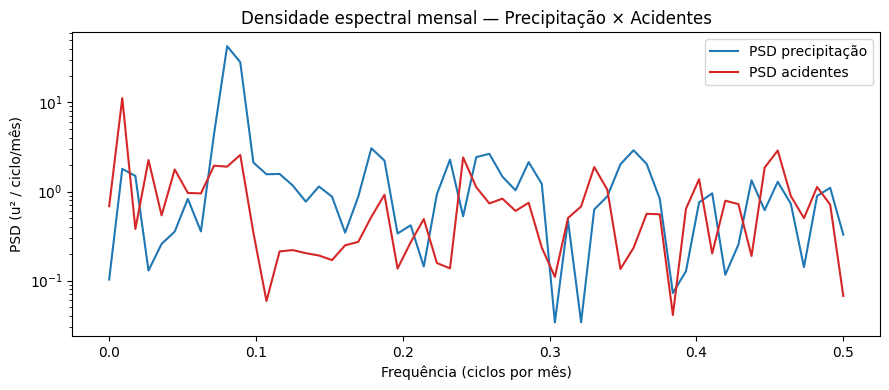

Coerência anual (1 ciclo/ano) = 0.62  →  relação clara


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, coherence

def relatorio_espectral(df_h: pd.DataFrame) -> None:
    """
    Gera um relatório rápido de relação chuva × acidentes:
    1) agrega df_h (horário) em séries mensais (soma);
    2) plota PSD das duas séries;
    3) calcula coerência na frequência anual (1/12 cpm) e imprime interpretação.

    Parâmetros
    ----------
    df_h : DataFrame
        Deve conter as colunas:
        - 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'
        - 'count'
        Index: DateTimeIndex horário.
    """

    # ------------- AGREGAÇÃO MENSAL ---------------------------------------
    df_month = (
        df_h
          .resample("ME")
          .agg({
              "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "sum",
              "count": "sum"
          })
          .rename(columns={
              "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "precip_total_mm",
              "count": "acidentes_mes"
          })
    )

    # ------------- PREPARA SÉRIES NUMPY -----------------------------------
    x = df_month["precip_total_mm"].to_numpy(float)
    y = df_month["acidentes_mes"].to_numpy(float)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    # Padroniza
    x = (x - x.mean()) / x.std(ddof=0)
    y = (y - y.mean()) / y.std(ddof=0)

    # ------------- PSD ----------------------------------------------------
    fs = 1                            # 1 ponto por mês
    nperseg = min(256, len(x))
    f_x, Pxx = welch(x, fs=fs, nperseg=nperseg, detrend=False, scaling="density")
    f_y, Pyy = welch(y, fs=fs, nperseg=nperseg, detrend=False, scaling="density")

    # ------------- PLOT PSD -----------------------------------------------
    plt.figure(figsize=(9, 4))
    plt.semilogy(f_x, Pxx, label="PSD precipitação", color="tab:blue")
    plt.semilogy(f_y, Pyy, label="PSD acidentes",   color="tab:red")
    plt.ylabel("PSD (u² / ciclo/mês)")
    plt.xlabel("Frequência (ciclos por mês)")
    plt.title("Densidade espectral mensal — Precipitação × Acidentes")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------- COERÊNCIA ANUAL ----------------------------------------
    nperseg_c = min(32, len(x))
    f_c, Cxy = coherence(
        x, y,
        fs=fs,
        nperseg=nperseg_c,
        noverlap=nperseg_c // 2,
        detrend="linear"
    )
    idx = np.argmin(np.abs(f_c - 1/12))
    coer_annual = Cxy[idx]

    # Interpretação simples
    if coer_annual >= 0.7:
        niv = "sincronismo forte"
    elif coer_annual >= 0.5:
        niv = "relação clara"
    elif coer_annual >= 0.3:
        niv = "influência moderada"
    else:
        niv = "relação fraca"

    print(f"Coerência anual (1 ciclo/ano) = {coer_annual:.2f}  →  {niv}")


relatorio_espectral(df_h)


| Faixa         | Interpretação                                                                                      |
| ------------- | -------------------------------------------------------------------------------------------------- |
| **≥ 0,7**     | Sincronismo forte: precipitação e acidentes exibem praticamente o mesmo ciclo anual.               |
| **0,5 – 0,7** | Relação clara: há correlação sazonal nítida, mas outros fatores também contribuem.                 |
| **0,3 – 0,5** | Influência moderada: a chuva explica parte do padrão anual dos acidentes, porém não domina.        |
| **< 0,3**     | Relação fraca ou inexistente: a sazonalidade dos acidentes independe, na prática, da precipitação. |
